In [6]:
import pandas as pd
import numpy as np

In [7]:
n = None
df_split = pd.read_csv("data/mimic_processed/ehr_combined.csv",
                       usecols=["hadm_id", "splits"]).drop_duplicates().set_index("hadm_id")
df = pd.read_csv("data/mimic_processed/ehr_combined_flat.csv", index_col="hadm_id", nrows=n)
df = df_split.join(df, how="right")
splits = df.splits
df = df.drop(columns="splits").astype(np.float32)

In [8]:
train_df = df[splits == "train"]
train_x, train_y = train_df.drop(columns="readmitted"), train_df.readmitted.values

val_df = df[splits == "val"]
val_x, val_y = val_df.drop(columns="readmitted"), val_df.readmitted.values

test_df = df[splits == "test"]
test_x, test_y = test_df.drop(columns="readmitted"), test_df.readmitted.values

Text(0.5, 1.0, 'Test auc: 0.675 95% CI: 0.669-0.681')

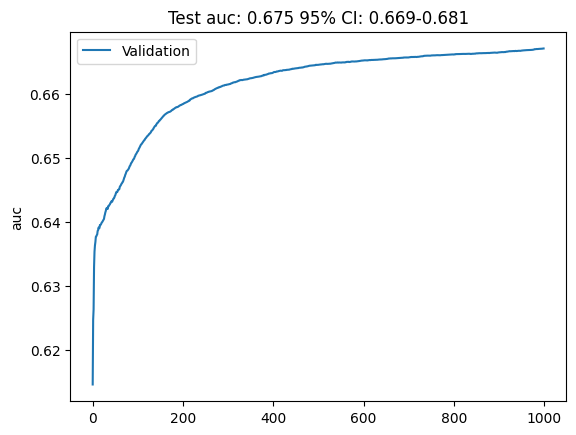

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)


model = XGBClassifier(
    n_jobs=-1, verbosity=1, device="cuda",
    eval_metric="auc", random_state=42,
    max_depth=8,
    min_child_weight=10,
    eta=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=1000,
    early_stopping_rounds=100,
)

model.fit(train_x, train_y, eval_set=[(val_x, val_y)], verbose=False)
results = model.evals_result()

epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Validation')
ax.legend()
plt.ylabel('auc')

test_pred = model.predict_proba(test_x)[:, 1]
test_auc = roc_auc_score(test_y, test_pred)

aucs = []
for _ in range(1000):
    idx = np.random.choice(len(test_y), len(test_y), replace=True)
    aucs.append(roc_auc_score(test_y[idx], test_pred[idx]))
ci_low = np.percentile(aucs, 2.5)
ci_high = np.percentile(aucs, 97.5)

plt.title(f"Test auc: {test_auc:.3f} 95% CI: {ci_low:.3f}-{ci_high:.3f}")

In [5]:
results.keys()

dict_keys(['validation_0'])